In [12]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk

In [5]:
#1: Load data and explore
read = pd.read_csv("AB_NYC_2019.csv")
df = pd.DataFrame(read)


In [6]:
#48895 rows and 16 columns
print(df.shape)

#Count values and check for nulls
print(df.neighbourhood_group.value_counts())
print(df.neighbourhood.value_counts())
print(df.room_type.value_counts())
print(df.isnull().sum())
pd.set_option("display.max_rows", 10, "display.max_columns", None)

(48895, 16)
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Willowbrook              1
New Dorp                 1
Rossville                1
Richmondtown             1
Fort Wadsworth           1
Name: neighbourhood, Length: 221, dtype: int64
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                   

In [7]:
#Drop irrelevant columns and rename certain columns
#Error will be show in drop line but still works in following code
df.drop(columns = ['id', 'name', 'last_review'], axis=1, inplace = True)
df.rename(columns = {"number_of_reviews": "review_count", "calculated_host_listings_count": "host_listings_count"}, inplace = True)

#Many nulls in reviews_per_month
#columns that need to be looked into: min/max of price, max of minimum_nights, and min to 25 percentile of availability_365

In [8]:
#2: Data cleansing

#Look into 21 null host_name(s)
df.loc[df["host_id"].isin(df[df['host_name'].isnull()].host_id)]
#Keep hosts without host names as everything else looks fine and use host_id as primary key therefore we will drop host names
df.drop(columns = "host_name", axis = 1, inplace = True)
#Look into null reviews per month
df.loc[df["reviews_per_month"].isnull()]
#replace nulls with 0 as nulls just never had a review to begin with
df.reviews_per_month.fillna(value = 0, inplace = True)
#only include listing with minimum nights one year and below
df = df.loc[df['minimum_nights'] <= 365]
df['host_listings_count'] = df.groupby('host_id')['host_id'].transform('count')


#get rid of listings with outlier prices
quantile05 = df.quantile(0.02)['price']
quantile95 = df.quantile(0.98)['price']
df = df[df["price"] < quantile95]
df = df[df["price"] > quantile05]
print(df.describe())

            host_id      latitude     longitude         price  minimum_nights  \
count  4.645100e+04  46451.000000  46451.000000  46451.000000    46451.000000   
mean   6.633939e+07     40.729295    -73.952492    135.164625        6.717875   
std    7.806401e+07      0.054148      0.045646     88.601306       16.177018   
min    2.438000e+03     40.499790    -74.244420     36.000000        1.000000   
25%    7.556128e+06     40.690425    -73.983070     70.000000        1.000000   
50%    2.993626e+07     40.723240    -73.955830    109.000000        2.000000   
75%    1.055811e+08     40.763430    -73.937160    175.000000        5.000000   
max    2.743213e+08     40.913060    -73.712990    549.000000      365.000000   

       review_count  reviews_per_month  host_listings_count  availability_365  
count  46451.000000       46451.000000         46451.000000      46451.000000  
mean      23.760479           1.102829             7.149125        111.197046  
std       45.067693           

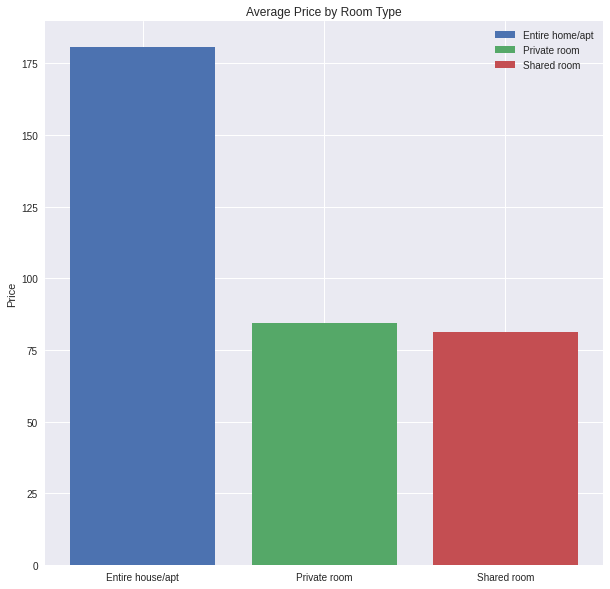

In [9]:
#3 EDA Analysis

#Most expensive/cheapest areas


#Plot bar chart
plt.style.use('seaborn')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
labels = ["Entire house/apt", "Private room", "Shared room"]
e_house = df.loc[df.room_type == "Entire home/apt", ["price"]]
private_r = df.loc[df.room_type == "Private room", ["price"]]
r_room = df.loc[df.room_type == "Shared room", ["price"]]
ax.bar(1, height = e_house.mean(), label='Entire home/apt')
ax.bar(2,height = private_r.mean(), label='Private room')
ax.bar(3, height = r_room.mean(), label='Shared room')
plt.legend(loc='best')
ax.set_ylabel('Price', rotation = 90)
ax.set_xticks([1,2,3])
ax.set_xticklabels(labels)
plt.title("Average Price by Room Type")
plt.show()

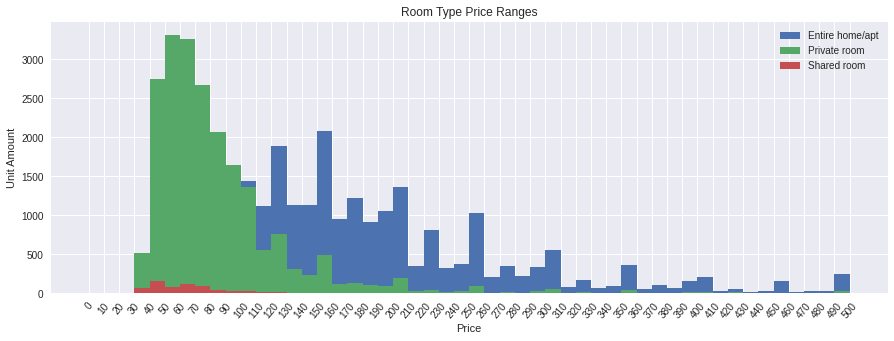

In [10]:
# Plot histogram of housing types and prices
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
e_house = df.groupby('room_type').get_group('Entire home/apt')
p_room = df.groupby('room_type').get_group('Private room')
r_room = df.groupby('room_type').get_group('Shared room')
ax.hist(e_house.price, bins = range(0, 510, 10), label='Entire home/apt')
ax.hist(private_r.price, bins = range(0,510,10), label='Private room')
ax.hist(r_room.price, bins = range(0, 510, 10), label='Shared room')
plt.legend(loc='best')
ax.set_ylabel('Unit Amount')
plt.xlabel('Price')
plt.xticks(range(0, 510, 10), rotation=50)
plt.title("Room Type Price Ranges")
plt.show()

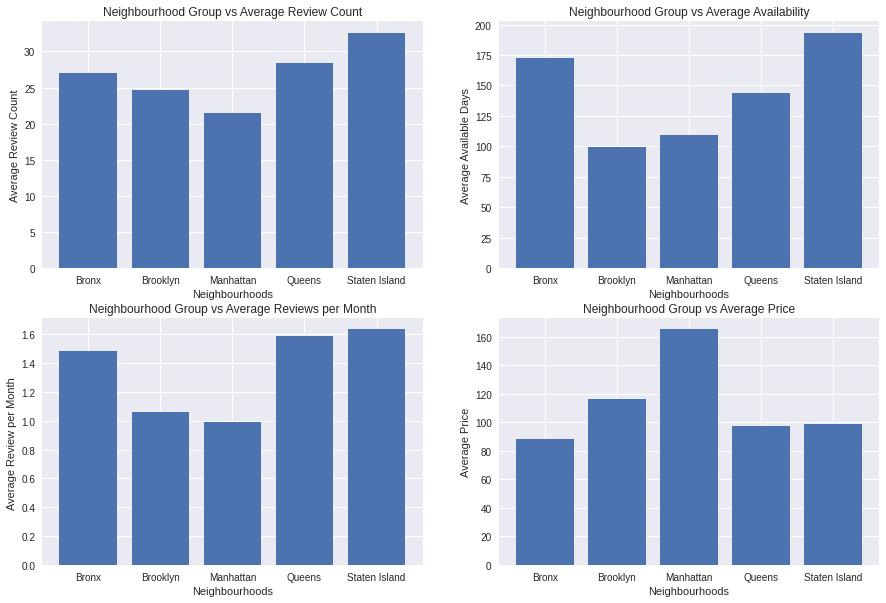

In [11]:
#Plot neighborhood groups based on other columns
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.title.set_text('Neighbourhood Group vs Average Review Count')
ax2.title.set_text('Neighbourhood Group vs Average Availability')
ax3.title.set_text('Neighbourhood Group vs Average Reviews per Month')
ax4.title.set_text('Neighbourhood Group vs Average Price')

labels = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
ax1.bar(labels, height = df.groupby(['neighbourhood_group']).mean().loc[:, 'review_count'])
ax1.set_ylabel('Average Review Count', rotation = 90)
ax1.set_xlabel('Neighbourhoods')
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(labels)
ax2.bar(labels, height = df.groupby(['neighbourhood_group']).mean().loc[:, 'availability_365'])
ax2.set_ylabel('Average Available Days', rotation = 90)
ax2.set_xlabel('Neighbourhoods')
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(labels)
ax3.bar(labels, height = df.groupby(['neighbourhood_group']).mean().loc[:, 'reviews_per_month'])
ax3.set_ylabel('Average Review per Month ', rotation = 90)
ax3.set_xlabel('Neighbourhoods')
ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(labels)
ax4.bar(labels, height = df.groupby(['neighbourhood_group']).mean().loc[:, 'price'])
ax4.set_ylabel('Average Price', rotation = 90)
ax4.set_xlabel('Neighbourhoods')
ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels(labels)
plt.show()

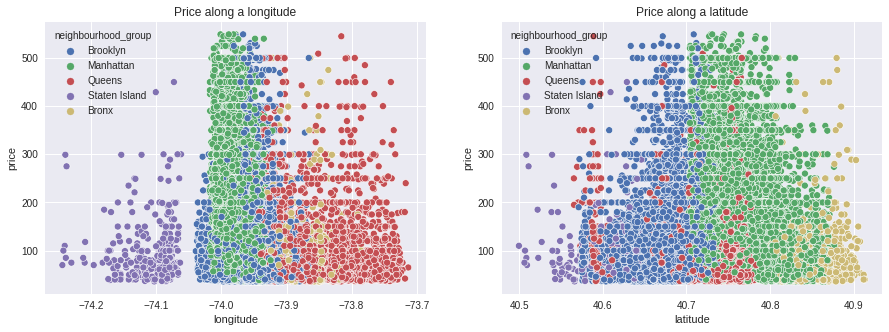

In [16]:
#4 Hypothesis testing

#4.1 Listings will get progressively more expensive as you get closers towards the center of NYC or the Manhattan area
fig=plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
ax5 = fig.add_subplot(1,2,1)
ax6 = fig.add_subplot(1,2,2)

sns.scatterplot(x='longitude', y='price', hue='neighbourhood_group', data=df, ax=ax5)
sns.scatterplot(x='latitude', y='price', hue='neighbourhood_group', data=df, ax=ax6)

ax5.set_title('Price along a longitude')
ax6.set_title('Price along a latitude')
plt.show()

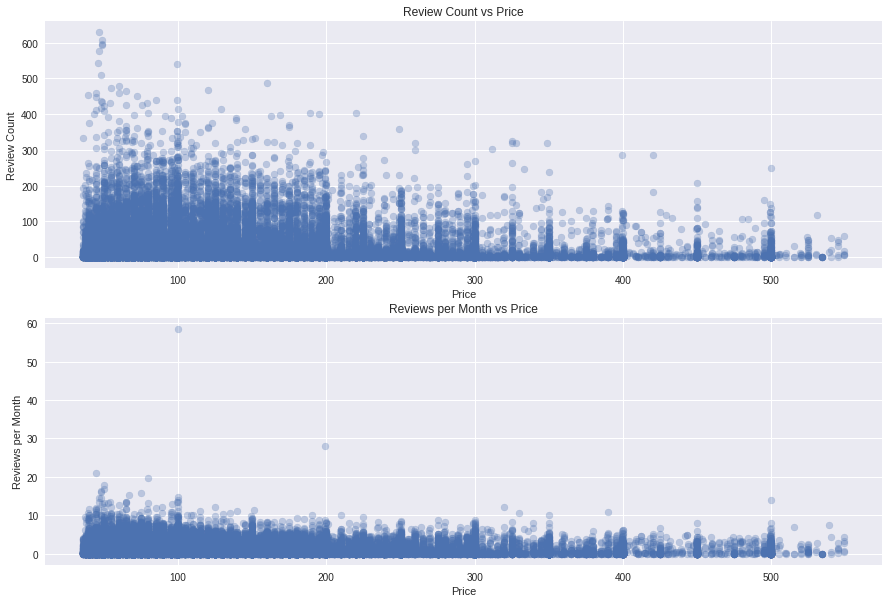

In [14]:
#4.2 There is a negative correlation between price and review counts

fig = plt.figure(figsize=(15,10))
ax7 = fig.add_subplot(2,1,1)
ax8 = fig.add_subplot(2,1,2)
ax7.title.set_text('Review Count vs Price')
ax8.title.set_text('Reviews per Month vs Price')

ax7.scatter(df['price'], df['review_count'], cmap=plt.get_cmap('jet'), alpha=0.3)
ax7.set_ylabel('Review Count', rotation = 90)
ax7.set_xlabel('Price')
ax8.scatter(df['price'], df['reviews_per_month'], cmap=plt.get_cmap('jet'), alpha=0.3)
ax8.set_ylabel('Reviews per Month', rotation = 90)
ax8.set_xlabel('Price')
plt.show()

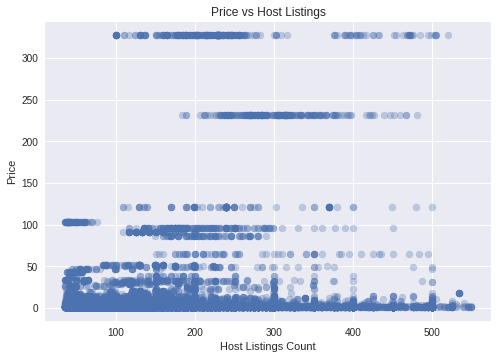

In [17]:
#4.3 There is a positive correlation between host listing counts and price
plt.scatter(df['price'], df['host_listings_count'], cmap=plt.get_cmap('jet'), alpha=0.3)
plt.title("Price vs Host Listings")
plt.ylabel("Price")
plt.xlabel("Host Listings Count")
plt.show()